# **<center>PROJECT - IE7275 - GROUP1</center>**


# **INTRODUCTION**

With an estimated audience of 12 million people every game, the English Premier Competition is the most watched professional soccer league on the planet. In comparison, La Liga in Spain draws an average of just over 2 million spectators per game.

There are 20 teams competing for first place in the EPL. The team with the most points at the end of the season is the victor, with three points granted for a win, one point for a tie, and none for a loss. The bottom three teams are relegated and replaced with better-performing teams from lesser divisions. Every team plays each other twice, once at home and once on the road. Thus, there are a total of 380 games per season. A season runs from August to May of the following year.

Soccer analytics is attracting an increasing interest of academia and industry, thanks to the availability of sensing technologies that provide high-fidelity data streams extracted from every match. Soccer is played by 250 million players in over 200 countries (most popular sport globally). Using this information along with team and player specific statistic we are working on soccer match prediction along with expected goal models. In this project we will be using information of matches over last 20 years and work on XGBoost, SVM and other regression classifiers for soccer match prediction. Challenges that we would be facing will be understanding on which features to use and how events can provide information for creating expected goal models which would show the probability of shot being converted into a goal.

Results in football, more so than any other sport, can be greatly influenced by random moments and “luck.” Near misses, deflected shots, goalkeeping errors, and controversial refereeing decisions alone can dictate the final result. Football is a game of inches.

Expected Goals Model(xG) measures the probability that a shot will result in a goal based on a number of factors. Such factors include the distance from where the shot was taken, angle with respect to the goal line, the game state (what is the score), if it was a header, if the shot came during a counter attack and other factors. For the purpose of simplicity, our exploration will focus on just three of these factors. We can use this metric to sum over all the chances in a match to determine how many goals a team should have scored



# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from datetime import datetime as dt
import itertools
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV

!pip install xgboost

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importing Data

In [ ]:
file_list = ['2000-01.csv','2001-02.csv','2002-03.csv','2004-05.csv','2005-06.csv','2006-07.csv','2007-08.csv','2008-09.csv','2009-10.csv',
             '2010-11.csv','2011-12.csv','2012-13.csv','2013-14.csv','2015-16.csv','2016-17.csv','2017-18.csv']
i=1
for ele in file_list:
  globals()[f"raw_data_{i}"] = pd.read_csv(ele)
  i+=1

Extracting particular columns from raw data

In [ ]:
columns_req = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR']
for i in range(1,17):
  globals()[f"playing_statistics_{i}"] = globals()[f"raw_data_{i}"][columns_req]

In [ ]:
playing_statistics_1.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,19/08/00,Charlton,Man City,4,0,H
1,19/08/00,Chelsea,West Ham,4,2,H
2,19/08/00,Coventry,Middlesbrough,1,3,A
3,19/08/00,Derby,Southampton,2,2,D
4,19/08/00,Leeds,Everton,2,0,H


# **Data Preprocessing**

 Goals Scored and Conceded at the end of Matchweek, Arranged by teams and Matchweek

In [ ]:
# Gets the goals scored agg arranged by teams and matchweek
def get_goals_scored(playing_stat):
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []
    
    # the value corresponding to keys is a list containing the match location.
    for i in range(len(playing_stat)):
        HTGS = playing_stat.iloc[i]['FTHG']
        ATGS = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGS)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGS)
    
    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsScored = pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
    GoalsScored[0] = 0
    # Aggregate to get uptil that point
    for i in range(2,39):
        GoalsScored[i] = GoalsScored[i] + GoalsScored[i-1]
    return GoalsScored


# Gets the goals conceded agg arranged by teams and matchweek
def get_goals_conceded(playing_stat):
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []
    
    # the value corresponding to keys is a list containing the match location.
    for i in range(len(playing_stat)):
        ATGC = playing_stat.iloc[i]['FTHG']
        HTGC = playing_stat.iloc[i]['FTAG']
        teams[playing_stat.iloc[i].HomeTeam].append(HTGC)
        teams[playing_stat.iloc[i].AwayTeam].append(ATGC)
    
    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsConceded = pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
    GoalsConceded[0] = 0
    # Aggregate to get uptil that point
    for i in range(2,39):
        GoalsConceded[i] = GoalsConceded[i] + GoalsConceded[i-1]
    return GoalsConceded

def get_gss(playing_stat):
    GC = get_goals_conceded(playing_stat)
    GS = get_goals_scored(playing_stat)
    j = 0
    HTGS = []
    ATGS = []
    HTGC = []
    ATGC = []
    for i in range(380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTGS.append(GS.loc[ht][j])
        ATGS.append(GS.loc[at][j])
        HTGC.append(GC.loc[ht][j])
        ATGC.append(GC.loc[at][j])
        if ((i + 1)% 10) == 0:
            j = j + 1
    playing_stat['HTGS'] = HTGS
    playing_stat['ATGS'] = ATGS
    playing_stat['HTGC'] = HTGC
    playing_stat['ATGC'] = ATGC
    return playing_stat

# Apply to each dataset
for i in range(1,17):
  globals()[f"playing_statistics_{i}"] = get_gss(globals()[f"playing_statistics_{i}"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Get Points for each team

In [ ]:
def get_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0

def get_cuml_points(matchres):
    matchres_points = matchres.applymap(get_points)
    for i in range(2,39):
        matchres_points[i] = matchres_points[i] + matchres_points[i-1]  
    matchres_points.insert(column =0, loc = 0, value = [0*i for i in range(20)])
    return matchres_points

def get_matchres(playing_stat):
    # Create a dictionary with team names as keys
    teams = {}
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = []
    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        if playing_stat.iloc[i].FTR == 'H':
            teams[playing_stat.iloc[i].HomeTeam].append('W')
            teams[playing_stat.iloc[i].AwayTeam].append('L')
        elif playing_stat.iloc[i].FTR == 'A':
            teams[playing_stat.iloc[i].AwayTeam].append('W')
            teams[playing_stat.iloc[i].HomeTeam].append('L')
        else:
            teams[playing_stat.iloc[i].AwayTeam].append('D')
            teams[playing_stat.iloc[i].HomeTeam].append('D')        
    return pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T

def get_agg_points(playing_stat):
    matchres = get_matchres(playing_stat)
    cum_pts = get_cuml_points(matchres)
    HTP = []
    ATP = []
    j = 0
    for i in range(380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        HTP.append(cum_pts.loc[ht][j])
        ATP.append(cum_pts.loc[at][j])
        if ((i + 1)% 10) == 0:
            j = j + 1      
    playing_stat['HTP'] = HTP
    playing_stat['ATP'] = ATP
    return playing_stat
    
for i in range(1,17):
  globals()[f"playing_statistics_{i}"] = get_agg_points(globals()[f"playing_statistics_{i}"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
playing_statistics_1

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP
0,19/08/00,Charlton,Man City,4,0,H,0,0,0,0,0,0
1,19/08/00,Chelsea,West Ham,4,2,H,0,0,0,0,0,0
2,19/08/00,Coventry,Middlesbrough,1,3,A,0,0,0,0,0,0
3,19/08/00,Derby,Southampton,2,2,D,0,0,0,0,0,0
4,19/08/00,Leeds,Everton,2,0,H,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
375,19/05/01,Man City,Chelsea,1,2,A,40,66,63,44,34,58
376,19/05/01,Middlesbrough,West Ham,2,1,H,42,44,43,48,39,42
377,19/05/01,Newcastle,Aston Villa,3,0,H,41,46,50,40,48,54
378,19/05/01,Southampton,Arsenal,3,2,H,37,61,46,35,49,70


Get Team Form

In [ ]:
def get_form(playing_stat,num):
    form = get_matchres(playing_stat)
    form_final = form.copy()
    for i in range(num,39):
        form_final[i] = ''
        j = 0
        while j < num:
            form_final[i] += form[i-j]
            j += 1           
    return form_final

def add_form(playing_stat,num):
    form = get_form(playing_stat,num)
    h = ['M' for i in range(num * 10)]  # since form is not available for n MW (n*10)
    a = ['M' for i in range(num * 10)]
    j = num
    for i in range((num*10),380):
        ht = playing_stat.iloc[i].HomeTeam
        at = playing_stat.iloc[i].AwayTeam
        past = form.loc[ht][j]               # get past n results
        h.append(past[num-1])                    # 0 index is most recent 
        past = form.loc[at][j]               # get past n results.
        a.append(past[num-1])                   # 0 index is most recent
        if ((i + 1)% 10) == 0:
            j = j + 1
    playing_stat['HM' + str(num)] = h                 
    playing_stat['AM' + str(num)] = a
    return playing_stat

def add_form_df(playing_statistics):
    for i in range(1,6):
      playing_statistics = add_form(playing_statistics, i)
    return playing_statistics    

for i in range(1,17):
  globals()[f"playing_statistics_{i}"] = add_form_df(globals()[f"playing_statistics_{i}"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Rearranging Columns for final dataset

In [ ]:
cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3',
        'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5' ]
for i in range(1,17):
  globals()[f"playing_statistics_{i}"] = globals()[f"playing_statistics_{i}"][cols]

Get Matchweek

In [ ]:
def get_mw(playing_stat):
    j = 1
    MatchWeek = []
    for i in range(380):
        MatchWeek.append(j)
        if ((i + 1)% 10) == 0:
            j = j + 1
    playing_stat['MW'] = MatchWeek
    return playing_stat
for i in range(1,17):
  globals()[f"playing_statistics_{i}"] = get_mw(globals()[f"playing_statistics_{i}"])

Final Dataframe

In [ ]:
playing_stat = pd.concat([playing_statistics_1,playing_statistics_2,playing_statistics_3,playing_statistics_4,playing_statistics_5,playing_statistics_6,playing_statistics_7,playing_statistics_8,playing_statistics_9,playing_statistics_10,
                          playing_statistics_11,playing_statistics_12,playing_statistics_13,playing_statistics_14,playing_statistics_15, playing_statistics_16], ignore_index=True)

# Gets the form points.
def get_form_points(string):
    sum = 0
    for letter in string:
        sum += get_points(letter)
    return sum

playing_stat['HTFormPtsStr'] = playing_stat['HM1'] + playing_stat['HM2'] + playing_stat['HM3'] + playing_stat['HM4'] + playing_stat['HM5']
playing_stat['ATFormPtsStr'] = playing_stat['AM1'] + playing_stat['AM2'] + playing_stat['AM3'] + playing_stat['AM4'] + playing_stat['AM5']
playing_stat['HTFormPts'] = playing_stat['HTFormPtsStr'].apply(get_form_points)
playing_stat['ATFormPts'] = playing_stat['ATFormPtsStr'].apply(get_form_points)

# Identify Win/Loss Streaks if any.
def get_3game_ws(string):
    if string[-3:] == 'WWW':
        return 1
    else:
        return 0
    
def get_5game_ws(string):
    if string == 'WWWWW':
        return 1
    else:
        return 0
    
def get_3game_ls(string):
    if string[-3:] == 'LLL':
        return 1
    else:
        return 0
    
def get_5game_ls(string):
    if string == 'LLLLL':
        return 1
    else:
        return 0
    
playing_stat['HTWinStreak3'] = playing_stat['HTFormPtsStr'].apply(get_3game_ws)
playing_stat['HTWinStreak5'] = playing_stat['HTFormPtsStr'].apply(get_5game_ws)
playing_stat['HTLossStreak3'] = playing_stat['HTFormPtsStr'].apply(get_3game_ls)
playing_stat['HTLossStreak5'] = playing_stat['HTFormPtsStr'].apply(get_5game_ls)
playing_stat['ATWinStreak3'] = playing_stat['ATFormPtsStr'].apply(get_3game_ws)
playing_stat['ATWinStreak5'] = playing_stat['ATFormPtsStr'].apply(get_5game_ws)
playing_stat['ATLossStreak3'] = playing_stat['ATFormPtsStr'].apply(get_3game_ls)
playing_stat['ATLossStreak5'] = playing_stat['ATFormPtsStr'].apply(get_5game_ls)
playing_stat.keys()

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS',
       'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1',
       'AM2', 'AM3', 'AM4', 'AM5', 'MW', 'HTFormPtsStr', 'ATFormPtsStr',
       'HTFormPts', 'ATFormPts', 'HTWinStreak3', 'HTWinStreak5',
       'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5',
       'ATLossStreak3', 'ATLossStreak5'],
      dtype='object')

In [ ]:
# Get Goal Difference
playing_stat['HTGD'] = playing_stat['HTGS'] - playing_stat['HTGC']
playing_stat['ATGD'] = playing_stat['ATGS'] - playing_stat['ATGC']
# Diff in points
playing_stat['DiffPts'] = playing_stat['HTP'] - playing_stat['ATP']
playing_stat['DiffFormPts'] = playing_stat['HTFormPts'] - playing_stat['ATFormPts']

In [ ]:
# Scale DiffPts , DiffFormPts, HTGD, ATGD by Matchweek.
cols = ['HTGD','ATGD','DiffPts','DiffFormPts','HTP','ATP']
playing_stat.MW = playing_stat.MW.astype(float)
for col in cols:
    playing_stat[col] = playing_stat[col] / playing_stat.MW

In [ ]:
def only_hw(string):
    if string == 'H':
        return 'H'
    else:
        return 'NH'
playing_stat['FTR'] = playing_stat.FTR.apply(only_hw)
# Testing set (2015-16 season)
playing_stat_test = playing_stat[5700:]

Saving the final dataset

In [ ]:
#saving the final dataset
playing_stat.to_csv('final_dataset.csv')

In [ ]:
#saving the test set
playing_stat_test.to_csv("test_set.csv")

Loading Dataframe

In [ ]:
#loading the final dataset
df_final_football = pd.read_csv('final_dataset.csv')
df_merge = df_final_football

In [ ]:
df_merge['Winner']='NA'
df_merge.head()

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,Winner
0,0,19/08/00,Charlton,Man City,4,0,H,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,NA
1,1,19/08/00,Chelsea,West Ham,4,2,H,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,NA
2,2,19/08/00,Coventry,Middlesbrough,1,3,NH,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,NA
3,3,19/08/00,Derby,Southampton,2,2,NH,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,NA
4,4,19/08/00,Leeds,Everton,2,0,H,0,0,0,0,0.0,0.0,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,NA


In [ ]:
df_merge['Winner'][df_merge['FTR']=='H']=df_merge['HomeTeam']
df_merge['Winner'][df_merge['FTR']=='A']=df_merge['AwayTeam']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_merge.dropna(axis=0,how='all',inplace=True)
len(df_merge)-df_merge.count()

Unnamed: 0       0
Date             0
HomeTeam         0
AwayTeam         0
FTHG             0
FTAG             0
FTR              0
HTGS             0
ATGS             0
HTGC             0
ATGC             0
HTP              0
ATP              0
HM1              0
HM2              0
HM3              0
HM4              0
HM5              0
AM1              0
AM2              0
AM3              0
AM4              0
AM5              0
MW               0
HTFormPtsStr     0
ATFormPtsStr     0
HTFormPts        0
ATFormPts        0
HTWinStreak3     0
HTWinStreak5     0
HTLossStreak3    0
HTLossStreak5    0
ATWinStreak3     0
ATWinStreak5     0
ATLossStreak3    0
ATLossStreak5    0
HTGD             0
ATGD             0
DiffPts          0
DiffFormPts      0
Winner           0
dtype: int64

In [ ]:
from collections import Counter
htmc=Counter(df_merge.HomeTeam)
print('Home Team Match:',htmc)

Home Team Match: Counter({'Chelsea': 304, 'Liverpool': 304, 'Tottenham': 304, 'Man United': 304, 'Arsenal': 304, 'Everton': 304, 'Man City': 285, 'Newcastle': 266, 'West Ham': 266, 'Aston Villa': 266, 'Sunderland': 247, 'Fulham': 228, 'West Brom': 209, 'Bolton': 190, 'Blackburn': 190, 'Southampton': 171, 'Stoke': 171, 'Middlesbrough': 152, 'Wigan': 152, 'Charlton': 114, 'Birmingham': 114, 'Portsmouth': 114, 'Swansea': 114, 'Leicester': 95, 'Norwich': 95, 'Crystal Palace': 95, 'Watford': 76, 'Hull': 76, 'Derby': 57, 'Leeds': 57, 'Reading': 57, 'Wolves': 57, 'Burnley': 57, 'Bournemouth': 57, 'Ipswich': 38, 'QPR': 38, 'Coventry': 19, 'Bradford': 19, 'Middlesboro': 19, 'Sheffield United': 19, 'Blackpool': 19, 'Cardiff': 19, 'Brighton': 19, 'Huddersfield': 19})


## **Data Visualisation**

Text(0.5, 0, 'Count of matches')

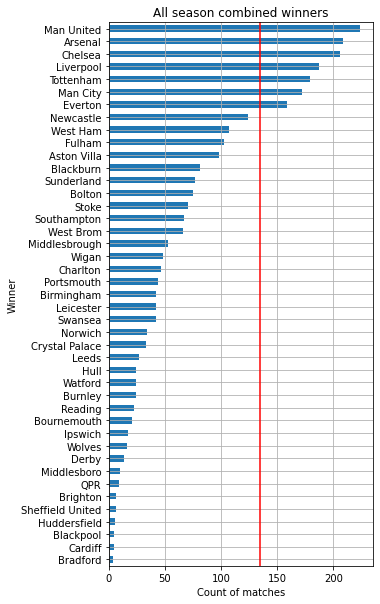

In [ ]:
plt.figure(figsize=(18,10))
plt.subplots_adjust(hspace=0.2,wspace=0.4)
plt.subplot(1,3,1)
df_merge.groupby('Winner').count()['FTR'].sort_values(ascending=True).iloc[1:-1].plot(kind='barh',grid=True)
plt.axvline(np.mean(df_merge.groupby('Winner').count()['FTR']),color='r')
plt.title('All season combined winners')
plt.xlabel('Count of matches')

Goal made by team in Home Ground and Away Ground

In [ ]:
pd.set_option('display.max_columns',500)
df_goal=df_merge.pivot_table(values=['FTHG','FTAG'],index='HomeTeam',columns='AwayTeam',aggfunc='sum')

Text(0.5, 1.0, 'Total goal at Away Ground')

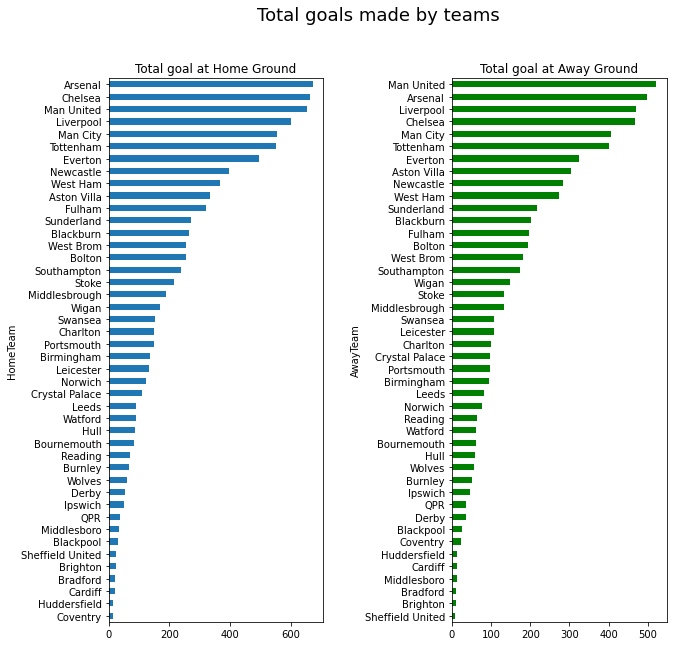

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace= .6)
plt.suptitle('Total goals made by teams',fontsize=18)
plt.subplot(1,2,1)
df_goal.xs('FTHG',level=0,axis=1).sum(axis=1).sort_values(ascending=True).plot(kind='barh')
plt.title('Total goal at Home Ground')
plt.subplot(1,2,2)
df_goal.xs('FTAG',level=0,axis=1).sum(axis=0).sort_values().plot(kind='barh',color='g')
plt.title('Total goal at Away Ground')

Below heatmap shows Team score how many goals against which team on both Home and Away Ground

Text(0.5, 1.0, 'Score of Teams at Away Ground')

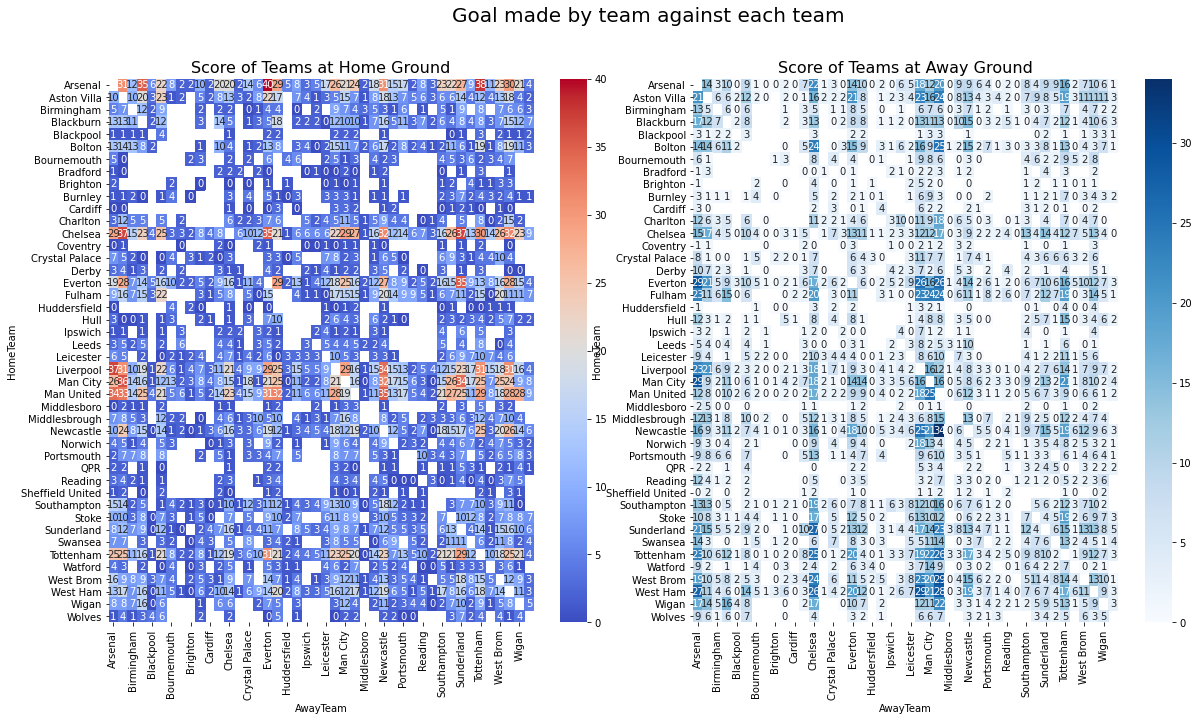

In [ ]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.1)
plt.suptitle('Goal made by team against each team',fontsize=20)
plt.subplot(1,2,1)
sns.heatmap(df_goal.xs('FTHG',level=0,axis=1),cmap='coolwarm',annot=True)
plt.title('Score of Teams at Home Ground', fontsize=16)
#sns.heatmap(df_HGgoal.xs)
plt.subplot(1,2,2)
sns.heatmap(df_goal.xs('FTAG',level=0,axis=1),cmap='Blues',annot=True)
plt.title('Score of Teams at Away Ground',fontsize=16)

corelation between Number of matches won verses goal scored

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Corelation of Win vs Score')

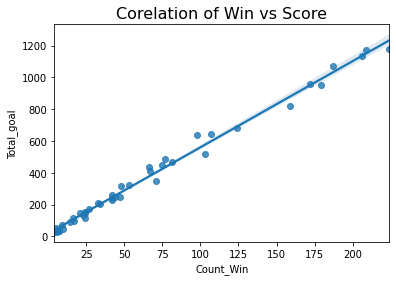

In [ ]:
df_win=df_merge.groupby('Winner').count()['FTR']
df_total_goals=df_goal.xs('FTHG',level=0,axis=1).sum(axis=1)+df_goal.xs('FTAG',level=0,axis=1).sum(axis=0)
df_win_goal=pd.concat({'Count_Win':df_win,'Total_goal':df_total_goals},axis=1).dropna()
#plt.scatter(df_win_goal.Count_Win,df_win_goal.Total_goal)
sns.regplot('Count_Win','Total_goal',df_win_goal)
plt.title('Corelation of Win vs Score',fontsize=16)

The .info() method allowed us to learn the shape of object types of our dataset.

In [ ]:
df_final_football.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6080 entries, 0 to 6079
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     6080 non-null   int64  
 1   Date           6080 non-null   object 
 2   HomeTeam       6080 non-null   object 
 3   AwayTeam       6080 non-null   object 
 4   FTHG           6080 non-null   int64  
 5   FTAG           6080 non-null   int64  
 6   FTR            6080 non-null   object 
 7   HTGS           6080 non-null   int64  
 8   ATGS           6080 non-null   int64  
 9   HTGC           6080 non-null   int64  
 10  ATGC           6080 non-null   int64  
 11  HTP            6080 non-null   float64
 12  ATP            6080 non-null   float64
 13  HM1            6080 non-null   object 
 14  HM2            6080 non-null   object 
 15  HM3            6080 non-null   object 
 16  HM4            6080 non-null   object 
 17  HM5            6080 non-null   object 
 18  AM1     

The .describe() method gives us summary statistics for numerical columns in our DataFrame.


In [ ]:
df_final_football.describe()

,Unnamed: 0,FTHG,FTAG,HTGS,ATGS,HTGC,ATGC,HTP,ATP,MW,HTFormPts,ATFormPts,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts
count,6080.00000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000
mean,3039.50000,1.532237,1.130921,24.440625,24.540954,24.527467,24.366283,1.209140,1.228347,19.500000,6.236184,6.424836,0.062829,0.018092,0.057072,0.014474,0.063487,0.016776,0.051974,0.010362,-0.010744,0.014894,-0.019207,-0.019919
std,1755.28915,1.298492,1.129964,17.290920,17.264619,16.464388,16.405333,0.531170,0.522946,10.966758,3.587114,3.552016,0.242675,0.133296,0.232000,0.119443,0.243857,0.128443,0.221992,0.101273,0.697592,0.697123,0.670326,0.409228
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,-3.333333,-2.363636,-2.250000
25%,1519.75000,1.000000,0.000000,10.000000,11.000000,11.000000,11.000000,0.888095,0.909091,10.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,-0.473684,-0.458333,-0.176471
50%,3039.50000,1.000000,1.000000,23.000000,23.000000,23.000000,23.000000,1.173163,1.191392,19.500000,6.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.076923,-0.050000,0.000000,0.000000
75%,4559.25000,2.000000,2.000000,35.000000,35.000000,36.000000,36.000000,1.571429,1.571429,29.000000,9.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.428571,0.428571,0.153846
max,6079.00000,9.000000,7.000000,102.000000,105.000000,85.000000,82.000000,2.736842,2.761905,38.000000,15.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,3.500000,2.285714,2.250000


Total null values has been calculated for each column and after Verifying, we found there are no null values in our dataset.

In [ ]:
#Checking for total NA's
df_final_football.isnull().sum()

Unnamed: 0       0
Date             0
HomeTeam         0
AwayTeam         0
FTHG             0
FTAG             0
FTR              0
HTGS             0
ATGS             0
HTGC             0
ATGC             0
HTP              0
ATP              0
HM1              0
HM2              0
HM3              0
HM4              0
HM5              0
AM1              0
AM2              0
AM3              0
AM4              0
AM5              0
MW               0
HTFormPtsStr     0
ATFormPtsStr     0
HTFormPts        0
ATFormPts        0
HTWinStreak3     0
HTWinStreak5     0
HTLossStreak3    0
HTLossStreak5    0
ATWinStreak3     0
ATWinStreak5     0
ATLossStreak3    0
ATLossStreak5    0
HTGD             0
ATGD             0
DiffPts          0
DiffFormPts      0
Winner           0
dtype: int64

POSITIVE CORRELATION: If an increase in feature A leads to increase in feature B, then they are positively correlated. A value 1 means perfect positive correlation.

NEGATIVE CORRELATION: If an increase in feature A leads to decrease in feature B, then they are negatively correlated. A value -1 means perfect negative correlation.

In the below heatmap, we have found the correlation of each columns with the rest of the dataset. 

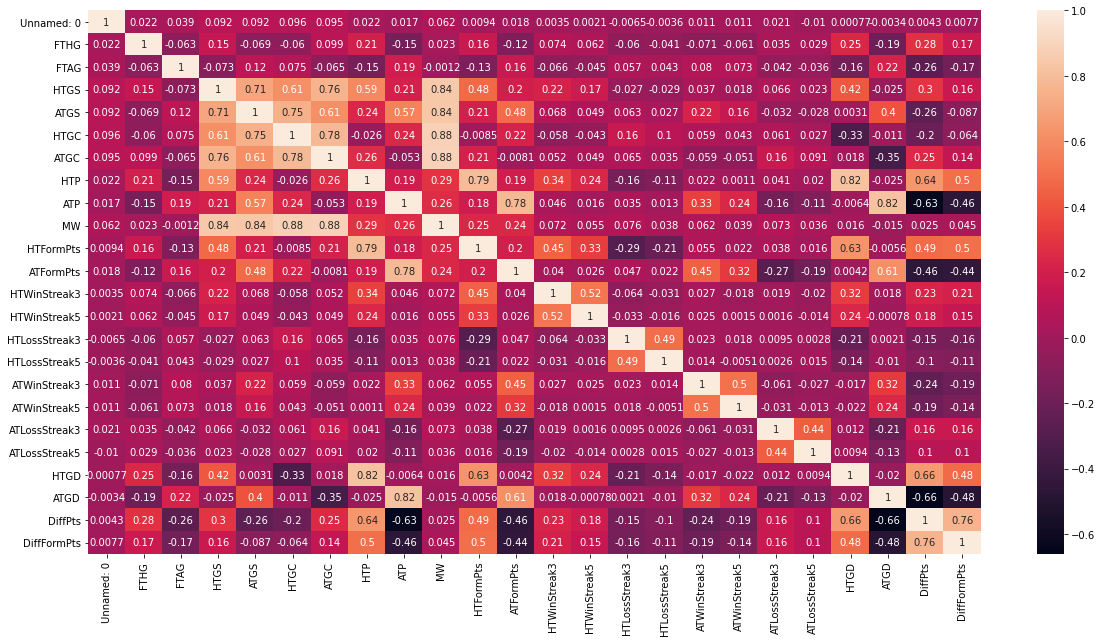

In [ ]:
#Correlation Matrix for dataset

plt.figure(figsize=(20,10)) 
sns.heatmap(df_final_football.corr(), annot= True)

A month column has been created using datetimeIndex on date column which can be used to sort the matches by months.

In [ ]:
#Extracting month and creating a new column
#df_final_football['month'] = pd.DatetimeIndex(df_final_football['Date']).month

df_final_football=df_final_football.drop(columns=['Unnamed: 0'])
x = df_final_football.pop('FTR')
df_final_football.insert(39,'FTR', x)

df_final_football

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,Winner,FTR
0,19/08/00,Charlton,Man City,4,0,0,0,0,0,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,Charlton,H
1,19/08/00,Chelsea,West Ham,4,2,0,0,0,0,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,Chelsea,H
2,19/08/00,Coventry,Middlesbrough,1,3,0,0,0,0,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,NA,NH
3,19/08/00,Derby,Southampton,2,2,0,0,0,0,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,NA,NH
4,19/08/00,Leeds,Everton,2,0,0,0,0,0,0.000000,0.000000,M,M,M,M,M,M,M,M,M,M,1.0,MMMMM,MMMMM,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,Leeds,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,13/05/18,Newcastle,Chelsea,3,0,36,62,47,35,1.078947,1.842105,L,L,L,L,W,D,W,W,W,W,38.0,LLLLW,DWWWW,3,13,0,0,0,0,1,0,0,0,-0.289474,0.710526,-0.763158,-0.263158,Newcastle,H
6076,13/05/18,Southampton,Man City,0,1,37,105,55,27,0.947368,2.552632,W,D,W,D,L,W,D,W,W,W,38.0,WDWDL,WDWWW,8,13,0,0,0,0,1,0,0,0,-0.473684,2.052632,-1.605263,-0.131579,NA,NH
6077,13/05/18,Swansea,Stoke,1,2,27,33,54,67,0.868421,0.789474,L,L,L,L,D,L,D,D,D,L,38.0,LLLLD,LDDDL,1,3,0,0,0,0,0,0,0,0,-0.710526,-0.894737,0.078947,-0.052632,NA,NH
6078,13/05/18,Tottenham,Leicester,5,4,69,52,32,55,1.947368,1.236842,W,L,W,D,L,W,L,L,D,L,38.0,WLWDL,WLLDL,7,4,0,0,0,0,0,0,0,0,0.973684,-0.078947,0.710526,0.078947,Tottenham,H


In [ ]:
l=['HM1','HM2','HM3','HM4','HM5','AM1','AM2','AM3','AM4','AM5','HTFormPtsStr','ATFormPtsStr']

le=LabelEncoder()

df_final_football[l]=df_final_football[l].apply(le.fit_transform)
df_final_football_report =  df_final_football


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct=ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [38])], remainder='passthrough')
df_final_football['Winner']=np.array(ct.fit_transform(df_final_football))

In [ ]:
df_final_football

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,Winner,FTR
0,19/08/00,Charlton,Man City,4,0,0,0,0,0,0.000000,0.000000,2,2,2,2,2,2,2,2,2,2,1.0,229,236,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,H
1,19/08/00,Chelsea,West Ham,4,2,0,0,0,0,0.000000,0.000000,2,2,2,2,2,2,2,2,2,2,1.0,229,236,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,H
2,19/08/00,Coventry,Middlesbrough,1,3,0,0,0,0,0.000000,0.000000,2,2,2,2,2,2,2,2,2,2,1.0,229,236,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,NH
3,19/08/00,Derby,Southampton,2,2,0,0,0,0,0.000000,0.000000,2,2,2,2,2,2,2,2,2,2,1.0,229,236,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,NH
4,19/08/00,Leeds,Everton,2,0,0,0,0,0,0.000000,0.000000,2,2,2,2,2,2,2,2,2,2,1.0,229,236,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,13/05/18,Newcastle,Chelsea,3,0,36,62,47,35,1.078947,1.842105,1,1,1,1,3,0,3,3,3,3,38.0,170,115,3,13,0,0,0,0,1,0,0,0,-0.289474,0.710526,-0.763158,-0.263158,0,H
6076,13/05/18,Southampton,Man City,0,1,37,105,55,27,0.947368,2.552632,3,0,3,0,1,3,0,3,3,3,38.0,257,275,8,13,0,0,0,0,1,0,0,0,-0.473684,2.052632,-1.605263,-0.131579,0,NH
6077,13/05/18,Swansea,Stoke,1,2,27,33,54,67,0.868421,0.789474,1,1,1,1,0,1,0,0,0,1,38.0,167,117,1,3,0,0,0,0,0,0,0,0,-0.710526,-0.894737,0.078947,-0.052632,0,NH
6078,13/05/18,Tottenham,Leicester,5,4,69,52,32,55,1.947368,1.236842,3,1,3,0,1,3,1,1,0,1,38.0,297,290,7,4,0,0,0,0,0,0,0,0,0.973684,-0.078947,0.710526,0.078947,0,H


In [ ]:
sc=StandardScaler()
df_final_football.iloc[:, 3:-1]=sc.fit_transform(df_final_football.iloc[:, 3:-1])
df_final_football

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HM1,HM2,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,MW,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,Winner,FTR
0,19/08/00,Charlton,Man City,1.900641,-1.000929,-1.413611,-1.421576,-1.489851,-1.485388,-2.276560,-2.349090,0.479879,0.386367,0.398025,0.388307,0.394365,0.339318,0.421271,0.397550,0.400426,0.366550,-1.687055,0.419962,0.337042,-1.738639,-1.808934,-0.258923,-0.13574,-0.246022,-0.121187,-0.260366,-0.130624,-0.234143,-0.102325,0.015403,-0.021367,0.028655,0.048677,-0.188676,H
1,19/08/00,Chelsea,West Ham,1.900641,0.769184,-1.413611,-1.421576,-1.489851,-1.485388,-2.276560,-2.349090,0.479879,0.386367,0.398025,0.388307,0.394365,0.339318,0.421271,0.397550,0.400426,0.366550,-1.687055,0.419962,0.337042,-1.738639,-1.808934,-0.258923,-0.13574,-0.246022,-0.121187,-0.260366,-0.130624,-0.234143,-0.102325,0.015403,-0.021367,0.028655,0.048677,-0.188676,H
2,19/08/00,Coventry,Middlesbrough,-0.409922,1.654240,-1.413611,-1.421576,-1.489851,-1.485388,-2.276560,-2.349090,0.479879,0.386367,0.398025,0.388307,0.394365,0.339318,0.421271,0.397550,0.400426,0.366550,-1.687055,0.419962,0.337042,-1.738639,-1.808934,-0.258923,-0.13574,-0.246022,-0.121187,-0.260366,-0.130624,-0.234143,-0.102325,0.015403,-0.021367,0.028655,0.048677,-0.188676,NH
3,19/08/00,Derby,Southampton,0.360265,0.769184,-1.413611,-1.421576,-1.489851,-1.485388,-2.276560,-2.349090,0.479879,0.386367,0.398025,0.388307,0.394365,0.339318,0.421271,0.397550,0.400426,0.366550,-1.687055,0.419962,0.337042,-1.738639,-1.808934,-0.258923,-0.13574,-0.246022,-0.121187,-0.260366,-0.130624,-0.234143,-0.102325,0.015403,-0.021367,0.028655,0.048677,-0.188676,NH
4,19/08/00,Leeds,Everton,0.360265,-1.000929,-1.413611,-1.421576,-1.489851,-1.485388,-2.276560,-2.349090,0.479879,0.386367,0.398025,0.388307,0.394365,0.339318,0.421271,0.397550,0.400426,0.366550,-1.687055,0.419962,0.337042,-1.738639,-1.808934,-0.258923,-0.13574,-0.246022,-0.121187,-0.260366,-0.130624,-0.234143,-0.102325,0.015403,-0.021367,0.028655,0.048677,-0.188676,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,13/05/18,Newcastle,Chelsea,1.130453,-1.000929,0.668578,2.169879,1.365030,0.648240,-0.245126,1.173750,-0.364597,-0.442537,-0.444591,-0.466165,1.259349,-1.275598,1.258306,1.237114,1.254969,1.228688,1.687055,-0.198173,-0.871516,-0.902244,1.851260,-0.258923,-0.13574,-0.246022,-0.121187,3.840742,-0.130624,-0.234143,-0.102325,-0.399592,0.997944,-1.109925,-0.594435,-0.188676,H
6076,13/05/18,Southampton,Man City,-1.180110,-0.115873,0.726416,4.660726,1.850967,0.160554,-0.492862,2.532560,1.324355,-1.271440,1.240641,-1.320636,-0.470620,1.146777,-1.252799,1.237114,1.254969,1.228688,1.687055,0.713315,0.726577,0.491749,1.851260,-0.258923,-0.13574,-0.246022,-0.121187,3.840742,-0.130624,-0.234143,-0.102325,-0.663680,2.923308,-2.366290,-0.272879,-0.188676,NH
6077,13/05/18,Swansea,Stoke,-0.409922,0.769184,0.148031,0.490005,1.790225,2.598986,-0.641504,-0.839301,-0.364597,-0.442537,-0.444591,-0.466165,-1.335605,-0.468140,-1.252799,-1.281578,-1.308659,-0.495587,1.687055,-0.229604,-0.851540,-1.459841,-0.964274,-0.258923,-0.13574,-0.246022,-0.121187,-0.260366,-0.130624,-0.234143,-0.102325,-1.003222,-1.304943,0.146440,-0.079945,-0.188676,NH
6078,13/05/18,Tottenham,Leicester,2.670829,2.539297,2.577251,1.590612,0.453898,1.867456,1.389930,0.016245,1.324355,-0.442537,1.240641,-1.320636,-0.470620,1.146777,-0.415764,-0.442014,-1.308659,-0.495587,1.687055,1.132390,0.876399,0.212951,-0.682721,-0.258923,-0.13574,-0.246022,-0.121187,-0.260366,-0.130624,-0.234143,-0.102325,1.411296,-0.134624,1.088714,0.241611,-0.188676,H


In [ ]:
pc=PCA(n_components=23)
principalComponents=pc.fit_transform(df_final_football.iloc[:,3:-1])

print('Cummulative PCA Variance :', np.cumsum(pc.explained_variance_ratio_))
print('\n')

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
                          'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23'])

principalDf

x=df_final_football.iloc[:,-1]

df_final_football=df_final_football.iloc[: , :3]

df_final_football = pd.concat([df_final_football,principalDf, x], axis = 1)

Cummulative PCA Variance : [0.15848967 0.29513977 0.39764275 0.44591918 0.4926784  0.53315506
 0.572635   0.60767021 0.63872836 0.66789959 0.69532833 0.7226066
 0.74851876 0.77435897 0.79994618 0.82525436 0.8504307  0.87271305
 0.89254079 0.91067014 0.92606544 0.93991932 0.95271577]




In [ ]:
df_final_football

,Date,HomeTeam,AwayTeam,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,FTR
0,19/08/00,Charlton,Man City,0.079633,-4.399090,-1.570043,-0.143051,-0.826950,0.045382,0.145357,-0.298074,1.309306,1.082680,-0.138196,0.643113,-0.193079,-0.926834,-0.534980,0.469948,0.245400,-1.177559,-1.309864,-0.961309,-0.054894,0.178127,-1.167274,H
1,19/08/00,Chelsea,West Ham,0.306340,-4.338439,-1.586294,-0.190778,-0.880861,0.137151,0.132116,-0.023655,1.146574,0.769108,0.323014,1.079781,0.327937,-0.843385,0.487930,1.243007,0.600203,-0.723806,-1.460479,-0.575629,-0.035278,0.177698,-1.177007,H
2,19/08/00,Coventry,Middlesbrough,0.744676,-4.314671,-1.574817,-0.187689,-0.808078,0.346285,0.157734,0.795794,1.080921,-0.281218,0.235348,0.566923,0.443781,-0.511142,0.734763,0.906475,0.378151,0.868659,-1.614753,0.286835,0.000944,0.159484,-1.348599,NH
3,19/08/00,Derby,Southampton,0.522995,-4.342811,-1.573226,-0.172810,-0.814369,0.245984,0.153608,0.431172,1.157049,0.173415,0.110834,0.592320,0.231494,-0.649706,0.311515,0.760966,0.333901,0.186586,-1.513123,-0.129213,-0.017669,0.165698,-1.288157,NH
4,19/08/00,Leeds,Everton,0.296287,-4.403462,-1.556976,-0.125083,-0.760458,0.154214,0.166849,0.156753,1.319782,0.486988,-0.350376,0.155652,-0.289522,-0.733154,-0.711395,-0.012093,-0.020903,-0.267167,-1.362509,-0.514892,-0.037285,0.166127,-1.278424,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,13/05/18,Newcastle,Chelsea,2.411499,3.547900,0.657400,3.076840,1.435745,-0.853706,0.959640,-0.266098,0.440109,1.637608,0.341970,0.040520,-0.645800,-0.408005,-0.571673,0.368191,-1.105514,-1.299598,-1.251992,-0.029693,-0.476936,-0.194649,0.715215,H
6076,13/05/18,Southampton,Man City,4.032386,6.042105,-0.184885,2.069843,-0.737138,-0.716145,0.458685,1.295482,1.056656,0.290709,-0.038451,-0.286212,-1.538262,2.449111,0.937501,-1.824434,0.893813,-0.044041,-0.291629,-0.441125,-0.327695,-0.304587,0.544865,NH
6077,13/05/18,Swansea,Stoke,-0.252425,-0.139497,4.654330,0.120657,-0.282966,-0.256740,-0.767613,0.658457,1.294541,-0.532695,-0.088032,0.603053,0.589091,0.307364,-0.050245,0.332994,0.812120,0.488907,0.650648,0.280264,0.396575,-0.246430,-0.187483,NH
6078,13/05/18,Tottenham,Leicester,-2.425506,3.174085,1.448986,-1.386166,-2.059075,-0.658772,-0.873858,-0.622611,0.354046,0.464576,0.122023,1.167934,0.186067,1.356248,2.432278,2.395531,0.969801,-1.007041,0.070489,0.197210,0.199408,-0.010667,-1.401766,H


In [ ]:
df_final_football.iloc[:, 3:-1]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,0.079633,-4.399090,-1.570043,-0.143051,-0.826950,0.045382,0.145357,-0.298074,1.309306,1.082680,-0.138196,0.643113,-0.193079,-0.926834,-0.534980,0.469948,0.245400,-1.177559,-1.309864,-0.961309,-0.054894,0.178127,-1.167274
1,0.306340,-4.338439,-1.586294,-0.190778,-0.880861,0.137151,0.132116,-0.023655,1.146574,0.769108,0.323014,1.079781,0.327937,-0.843385,0.487930,1.243007,0.600203,-0.723806,-1.460479,-0.575629,-0.035278,0.177698,-1.177007
2,0.744676,-4.314671,-1.574817,-0.187689,-0.808078,0.346285,0.157734,0.795794,1.080921,-0.281218,0.235348,0.566923,0.443781,-0.511142,0.734763,0.906475,0.378151,0.868659,-1.614753,0.286835,0.000944,0.159484,-1.348599
3,0.522995,-4.342811,-1.573226,-0.172810,-0.814369,0.245984,0.153608,0.431172,1.157049,0.173415,0.110834,0.592320,0.231494,-0.649706,0.311515,0.760966,0.333901,0.186586,-1.513123,-0.129213,-0.017669,0.165698,-1.288157
4,0.296287,-4.403462,-1.556976,-0.125083,-0.760458,0.154214,0.166849,0.156753,1.319782,0.486988,-0.350376,0.155652,-0.289522,-0.733154,-0.711395,-0.012093,-0.020903,-0.267167,-1.362509,-0.514892,-0.037285,0.166127,-1.278424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,2.411499,3.547900,0.657400,3.076840,1.435745,-0.853706,0.959640,-0.266098,0.440109,1.637608,0.341970,0.040520,-0.645800,-0.408005,-0.571673,0.368191,-1.105514,-1.299598,-1.251992,-0.029693,-0.476936,-0.194649,0.715215
6076,4.032386,6.042105,-0.184885,2.069843,-0.737138,-0.716145,0.458685,1.295482,1.056656,0.290709,-0.038451,-0.286212,-1.538262,2.449111,0.937501,-1.824434,0.893813,-0.044041,-0.291629,-0.441125,-0.327695,-0.304587,0.544865
6077,-0.252425,-0.139497,4.654330,0.120657,-0.282966,-0.256740,-0.767613,0.658457,1.294541,-0.532695,-0.088032,0.603053,0.589091,0.307364,-0.050245,0.332994,0.812120,0.488907,0.650648,0.280264,0.396575,-0.246430,-0.187483
6078,-2.425506,3.174085,1.448986,-1.386166,-2.059075,-0.658772,-0.873858,-0.622611,0.354046,0.464576,0.122023,1.167934,0.186067,1.356248,2.432278,2.395531,0.969801,-1.007041,0.070489,0.197210,0.199408,-0.010667,-1.401766


# **Milestone 2**

In [ ]:
Final_match_report_2 = df_final_football_report.copy().drop(columns =['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG',
       'HTGS', 'ATGS', 'HTGC', 'ATGC',
       'HM4', 'HM5','AM4', 'AM5', 'MW', 'HTFormPtsStr',
       'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3',
       'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3',
       'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5',
       'DiffPts'] )

In [ ]:
Final_match_report_2.keys()

Index(['HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'AM1', 'AM2', 'AM3', 'HTGD', 'ATGD',
       'DiffFormPts', 'Winner', 'FTR'],
      dtype='object')

In [ ]:
Final_match_report_2.head(10)

,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,Winner,FTR
0,-2.27656,-2.34909,0.479879,0.386367,0.398025,0.339318,0.421271,0.39755,0.015403,-0.021367,0.048677,-0.188676,H
1,-2.27656,-2.34909,0.479879,0.386367,0.398025,0.339318,0.421271,0.39755,0.015403,-0.021367,0.048677,-0.188676,H
2,-2.27656,-2.34909,0.479879,0.386367,0.398025,0.339318,0.421271,0.39755,0.015403,-0.021367,0.048677,-0.188676,NH
3,-2.27656,-2.34909,0.479879,0.386367,0.398025,0.339318,0.421271,0.39755,0.015403,-0.021367,0.048677,-0.188676,NH
4,-2.27656,-2.34909,0.479879,0.386367,0.398025,0.339318,0.421271,0.39755,0.015403,-0.021367,0.048677,-0.188676,H
5,-2.27656,-2.34909,0.479879,0.386367,0.398025,0.339318,0.421271,0.39755,0.015403,-0.021367,0.048677,-0.188676,NH
6,-2.27656,-2.34909,0.479879,0.386367,0.398025,0.339318,0.421271,0.39755,0.015403,-0.021367,0.048677,-0.188676,H
7,-2.27656,-2.34909,0.479879,0.386367,0.398025,0.339318,0.421271,0.39755,0.015403,-0.021367,0.048677,-0.188676,H
8,-2.27656,-2.34909,0.479879,0.386367,0.398025,0.339318,0.421271,0.39755,0.015403,-0.021367,0.048677,-0.188676,H
9,-2.27656,-2.34909,0.479879,0.386367,0.398025,0.339318,0.421271,0.39755,0.015403,-0.021367,0.048677,-0.188676,H


In [ ]:
#what is the win rate for the home team?

# Total number of matches.
matches = Final_match_report_2.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
features = Final_match_report_2.shape[1] - 1

# Calculate matches won by home team.
homewins = len(Final_match_report_2[Final_match_report_2.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(homewins) / (matches)) * 100

# Print the results
print("Total number of matches: {}".format(matches))
print ("Number of features: {}".format(features))
print( "Number of matches won by home team: {}".format(homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 6080
Number of features: 12
Number of matches won by home team: 2837
Win rate of home team: 46.66%


In [ ]:
df_final_football['FTR']

0        H
1        H
2       NH
3       NH
4        H
        ..
6075     H
6076    NH
6077    NH
6078     H
6079     H
Name: FTR, Length: 6080, dtype: object

## Splitting the data into test and train

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(df_final_football.iloc[:, 3:-1], df_final_football.iloc[:, -1], test_size=0.3)

## Grid Search for KNN

In [ ]:
p={'n_neighbors':np.arange(1,30), 'metric': ['euclidean', 'manhattan', 'minkowski'], 'weights': ['uniform', 'distance']}

from sklearn.model_selection import GridSearchCV

knn=KNeighborsClassifier()
x=GridSearchCV(knn, p, cv=5, scoring='accuracy')

x.fit(df_final_football.iloc[:, 3:-1], df_final_football.iloc[:, -1])

results = pd.DataFrame(x.cv_results_)
print(tabulate(results, headers = 'keys', tablefmt = 'psql'))

+-----+-----------------+----------------+-------------------+------------------+----------------+---------------------+-----------------+-------------------------------------------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|     |   mean_fit_time |   std_fit_time |   mean_score_time |   std_score_time | param_metric   |   param_n_neighbors | param_weights   | params                                                            |   split0_test_score |   split1_test_score |   split2_test_score |   split3_test_score |   split4_test_score |   mean_test_score |   std_test_score |   rank_test_score |
|-----+-----------------+----------------+-------------------+------------------+----------------+---------------------+-----------------+-------------------------------------------------------------------+---------------------+--------------------

In [ ]:
print(tabulate(results[results['rank_test_score']== 1], headers = 'keys', tablefmt = 'psql'))

+-----+-----------------+----------------+-------------------+------------------+----------------+---------------------+-----------------+-------------------------------------------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|     |   mean_fit_time |   std_fit_time |   mean_score_time |   std_score_time | param_metric   |   param_n_neighbors | param_weights   | params                                                            |   split0_test_score |   split1_test_score |   split2_test_score |   split3_test_score |   split4_test_score |   mean_test_score |   std_test_score |   rank_test_score |
|-----+-----------------+----------------+-------------------+------------------+----------------+---------------------+-----------------+-------------------------------------------------------------------+---------------------+--------------------

## Grid Search for Decision Trees

In [ ]:
p = {'max_depth':np.arange(1,31), 'criterion': ['entropy', 'gini'], 'splitter': ['best', 'random']}


des=DecisionTreeClassifier()

x=GridSearchCV(des, p, cv=5, scoring='accuracy')

x.fit(df_final_football.iloc[:, 3:-1], df_final_football.iloc[:, -1])

results = pd.DataFrame(x.cv_results_)
print(tabulate(results, headers = 'keys', tablefmt = 'psql'))

+-----+-----------------+----------------+-------------------+------------------+-------------------+-------------------+------------------+-----------------------------------------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|     |   mean_fit_time |   std_fit_time |   mean_score_time |   std_score_time | param_criterion   |   param_max_depth | param_splitter   | params                                                          |   split0_test_score |   split1_test_score |   split2_test_score |   split3_test_score |   split4_test_score |   mean_test_score |   std_test_score |   rank_test_score |
|-----+-----------------+----------------+-------------------+------------------+-------------------+-------------------+------------------+-----------------------------------------------------------------+---------------------+--------------------

In [ ]:
print(tabulate(results[results['rank_test_score']== 1], headers = 'keys', tablefmt = 'psql'))

+----+-----------------+----------------+-------------------+------------------+-------------------+-------------------+------------------+---------------------------------------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|    |   mean_fit_time |   std_fit_time |   mean_score_time |   std_score_time | param_criterion   |   param_max_depth | param_splitter   | params                                                        |   split0_test_score |   split1_test_score |   split2_test_score |   split3_test_score |   split4_test_score |   mean_test_score |   std_test_score |   rank_test_score |
|----+-----------------+----------------+-------------------+------------------+-------------------+-------------------+------------------+---------------------------------------------------------------+---------------------+---------------------+-------

## Grid Search for Random Forest

In [ ]:
p={'criterion': ['gini', 'entropy'], 'class_weight': ['balanced', 'balanced_subsample']}


rf=RandomForestClassifier()

x=GridSearchCV(rf, p, cv=5, scoring='accuracy')

x.fit(df_final_football.iloc[:, 3:-1], df_final_football.iloc[:, -1])

results = pd.DataFrame(x.cv_results_)
print(tabulate(results, headers = 'keys', tablefmt = 'psql'))

+----+-----------------+----------------+-------------------+------------------+----------------------+-------------------+----------------------------------------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|    |   mean_fit_time |   std_fit_time |   mean_score_time |   std_score_time | param_class_weight   | param_criterion   | params                                                         |   split0_test_score |   split1_test_score |   split2_test_score |   split3_test_score |   split4_test_score |   mean_test_score |   std_test_score |   rank_test_score |
|----+-----------------+----------------+-------------------+------------------+----------------------+-------------------+----------------------------------------------------------------+---------------------+---------------------+---------------------+---------------------+--------

In [ ]:
print(tabulate(results[results['rank_test_score']== 1], headers = 'keys', tablefmt = 'psql'))

+----+-----------------+----------------+-------------------+------------------+----------------------+-------------------+---------------------------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|    |   mean_fit_time |   std_fit_time |   mean_score_time |   std_score_time | param_class_weight   | param_criterion   | params                                            |   split0_test_score |   split1_test_score |   split2_test_score |   split3_test_score |   split4_test_score |   mean_test_score |   std_test_score |   rank_test_score |
|----+-----------------+----------------+-------------------+------------------+----------------------+-------------------+---------------------------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+-----

## Grid Search for ANN

In [ ]:
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(activation='relu', optimizer='adam', loss='binary_crossentropy'):
  ann=tf.keras.models.Sequential()
  ann.add(tf.keras.layers.Dense(units=21, activation=activation))
  ann.add(tf.keras.layers.Dense(units=10, activation=activation))
  ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics =['accuracy'])

  return ann


p={'activation':['relu', 'tanh', 'sigmoid', 'linear'], 'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']}

model = KerasClassifier(create_model, verbose=0, epochs=100, batch_size=32)

x=GridSearchCV(estimator=model, param_grid=p, scoring='accuracy') 
x.fit(x_train, y_train)

results=pd.DataFrame(x.cv_results_)
results[results['rank_test_score']==1]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,15.862543,4.516671,0.136915,0.020945,relu,Nadam,"{'activation': 'relu', 'optimizer': 'Nadam'}",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1


## Grid Search for Ada-Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

p={'learning_rate':np.arange(0.03, 3, 0.02), 'algorithm':['SAMME', 'SAMME.R']}

ada=AdaBoostClassifier()
x=GridSearchCV(ada, p, scoring='accuracy', cv=5)

x.fit(x_train, y_train)

results=pd.DataFrame(x.cv_results_)

results[results['rank_test_score']==1 ]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:604: RuntimeWarning: overflow encountered in exp
  (sample_weight > 0))
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py:163: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/usr/local/lib/python3.7/dist-packag

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
203,0.777896,0.005365,0.016278,0.000618,SAMME.R,1.11,"{'algorithm': 'SAMME.R', 'learning_rate': 1.11...",0.921362,0.911868,0.93537,0.942421,0.920094,0.926223,0.011075,1


## Grid Search for XGBoost

In [ ]:
import xgboost as xgb

p={'learning_rate':np.arange(0.03, 3, 0.02), 'booster':['gbtree', 'gblinear', 'dart']}


xg=xgb.XGBClassifier()
x=GridSearchCV(xg, p, scoring='accuracy', cv=5)
x.fit(x_train, y_train)

results=pd.DataFrame(x.cv_results_)
results[results['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_booster,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
36,0.569039,0.005677,0.006621,0.000563,gbtree,0.75,"{'booster': 'gbtree', 'learning_rate': 0.75000...",0.978873,0.963572,0.962397,0.957697,0.962397,0.964987,0.00723,1
334,1.183142,0.007017,0.006577,0.000055,dart,0.75,"{'booster': 'dart', 'learning_rate': 0.7500000...",0.978873,0.963572,0.962397,0.957697,0.962397,0.964987,0.00723,1


## Finding Training and Testing Accuracy using Pipeline to find best model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb


def model():
  ann=tf.keras.models.Sequential()
  ann.add(tf.keras.layers.Dense(units=21, activation='relu'))
  ann.add(tf.keras.layers.Dense(units=11, activation='relu'))
  ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  ann.compile(optimizer='Adagrad', loss='binary_crossentropy', metrics =['accuracy'])

  return ann

mo = KerasClassifier(model, verbose=0, epochs=150, batch_size=32)
scores=pd.DataFrame(columns=['Model','Training Accuracy Score', 'Test Accuracy Score'])

pipe_log= Pipeline(steps=[('Logistic', LogisticRegression())])
pipe_knn=Pipeline(steps=[('KNN', KNeighborsClassifier(29, 'distance', metric='manhattan'))])
pipe_dt=Pipeline(steps=[('Decision Tree', DecisionTreeClassifier('entropy', 'best', 25))])
pipe_rf=Pipeline(steps=[('Random Forest', RandomForestClassifier(100, 'gini', class_weight='balanced_subsample'))])
pipe_svm=Pipeline(steps=[('SVC', SVC(kernel='rbf', degree=8))])
pipe_ann=Pipeline(steps=[('ANN', mo)])
pipe_ada=Pipeline(steps=[('Ada', AdaBoostClassifier(learning_rate=1.11))])
pipe_xg=Pipeline(steps=[('XGBoost', xgb.XGBClassifier(learning_rate=0.75, booster='gbtree'))])


m=['Logistic', 'KNN', 'Decision Trees', 'Random Forest', 'SVC', 'ANN', 'Ada', 'XGBoost']
pipe=[pipe_log, pipe_knn, pipe_dt, pipe_rf, pipe_svm, pipe_ann, pipe_ada, pipe_xg]
j=0

for i in pipe:
  x=i.fit(x_train, y_train)
  tra=accuracy_score(x.predict(x_train), y_train)
  tea=accuracy_score(x.predict(x_test), y_test)

  scores.loc[j]=[m[j],tra, tea]
  j+=1


scores

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

,Model,Training Accuracy Score,Test Accuracy Score
0,Logistic,0.997650,0.997259
1,KNN,1.000000,0.854715
2,Decision Trees,1.000000,0.871711
3,Random Forest,1.000000,0.932018
4,SVC,0.995771,0.987390
5,ANN,0.901316,0.894737
6,Ada,0.967575,0.943531
7,XGBoost,1.000000,0.986294


## **Finding Training and Testing Accuracy by Standardising the data and using pipeline to find best model**

In [ ]:
scores=pd.DataFrame(columns=['Model','Training Accuracy Score', 'Test Accuracy Score'])

pipe_log= Pipeline(steps=[('Scaling', StandardScaler()),('Logistic', LogisticRegression())])
pipe_knn=Pipeline(steps=[('Scaling', StandardScaler()),('KNN', KNeighborsClassifier(29, 'distance', metric='manhattan'))])
pipe_dt=Pipeline(steps=[('Scaling', StandardScaler()),('Decision Tree', DecisionTreeClassifier('entropy', 'best', 25))])
pipe_rf=Pipeline(steps=[('Scaling', StandardScaler()),('Random Forest', RandomForestClassifier(100, 'gini', class_weight='balanced_subsample'))])
pipe_svm=Pipeline(steps=[('Scaling', StandardScaler()),('SVC', SVC(kernel='rbf', degree=4))])
pipe_ann=Pipeline(steps=[('Scaling', StandardScaler()), ('ANN', mo)])
pipe_ada=Pipeline(steps=[('Scaling', StandardScaler()), ('Ada', AdaBoostClassifier(learning_rate=1.11))])
pipe_xg=Pipeline(steps=[('Scaling', StandardScaler()),('XGBoost', xgb.XGBClassifier(learning_rate=0.75, booster='gbtree'))])

m=['Logistic', 'KNN', 'Decision Trees', 'Random Forest', 'SVC', 'ANN', "Ada", "XGBoost"]
pipe=[pipe_log, pipe_knn, pipe_dt, pipe_rf, pipe_svm, pipe_ann, pipe_ada, pipe_xg]
j=0

for i in pipe:
  x=i.fit(x_train, y_train)
  tra=accuracy_score(x.predict(x_train), y_train)
  tea=accuracy_score(x.predict(x_test), y_test)

  scores.loc[j]=[m[j],tra, tea]
  j+=1


scores

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

,Model,Training Accuracy Score,Test Accuracy Score
0,Logistic,0.998120,0.996162
1,KNN,1.000000,0.887610
2,Decision Trees,1.000000,0.868969
3,Random Forest,1.000000,0.927083
4,SVC,0.996241,0.989035
5,ANN,0.946194,0.936952
6,Ada,0.967575,0.943531
7,XGBoost,1.000000,0.986294


## Separate into feature set and target variable 

In [ ]:
#FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
X_all = Final_match_report_2.drop(['FTR'],1)
y_all = Final_match_report_2['FTR']

# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['HTGD','ATGD','HTP','ATP']]
for col in cols:
    X_all[col] = scale(X_all[col])

In [ ]:
#last 3 wins for both sides
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

#we want continous variables that are integers for our input data, so lets remove any categorical variables
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print ("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (29 total features):
['HTP', 'ATP', 'HM1_-0.3645970657634538', 'HM1_-1.209073317131758', 'HM1_0.4798791856048505', 'HM1_1.3243554369731547', 'HM2_-0.44253653170644514', 'HM2_-1.2714404481498176', 'HM2_0.3863673847369273', 'HM2_1.2152713011802998', 'HM3_-0.4445908520665433', 'HM3_-1.2872069307961516', 'HM3_0.3980252266630649', 'HM3_1.240641305392673', 'AM1_-0.46813989530170186', 'AM1_-1.2755982111696016', 'AM1_0.339318420566198', 'AM1_1.146776736434098', 'AM2_-0.4157640905146348', 'AM2_-1.2527990806897937', 'AM2_0.42127089966052417', 'AM2_1.2583058898356831', 'AM3_-0.44201375716284613', 'AM3_-1.2815775320925884', 'AM3_0.39755001776689614', 'AM3_1.2371137926966385', 'HTGD', 'ATGD', 'DiffFormPts']


In [ ]:
X_all.head(10)

,HTP,ATP,HM1_-0.3645970657634538,HM1_-1.209073317131758,HM1_0.4798791856048505,HM1_1.3243554369731547,HM2_-0.44253653170644514,HM2_-1.2714404481498176,HM2_0.3863673847369273,HM2_1.2152713011802998,HM3_-0.4445908520665433,HM3_-1.2872069307961516,HM3_0.3980252266630649,HM3_1.240641305392673,AM1_-0.46813989530170186,AM1_-1.2755982111696016,AM1_0.339318420566198,AM1_1.146776736434098,AM2_-0.4157640905146348,AM2_-1.2527990806897937,AM2_0.42127089966052417,AM2_1.2583058898356831,AM3_-0.44201375716284613,AM3_-1.2815775320925884,AM3_0.39755001776689614,AM3_1.2371137926966385,HTGD,ATGD,DiffFormPts
0,-2.27656,-2.34909,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0.015403,-0.021367,0.048677
1,-2.27656,-2.34909,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0.015403,-0.021367,0.048677
2,-2.27656,-2.34909,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0.015403,-0.021367,0.048677
3,-2.27656,-2.34909,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0.015403,-0.021367,0.048677
4,-2.27656,-2.34909,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0.015403,-0.021367,0.048677
5,-2.27656,-2.34909,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0.015403,-0.021367,0.048677
6,-2.27656,-2.34909,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0.015403,-0.021367,0.048677
7,-2.27656,-2.34909,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0.015403,-0.021367,0.048677
8,-2.27656,-2.34909,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0.015403,-0.021367,0.048677
9,-2.27656,-2.34909,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0.015403,-0.021367,0.048677


# Spliting the dataset

In [ ]:
from sklearn.model_selection import train_test_split

# split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 0.3,
                                                    random_state = 2,
                                                    stratify = y_all)

# Applying the Logistic Regression

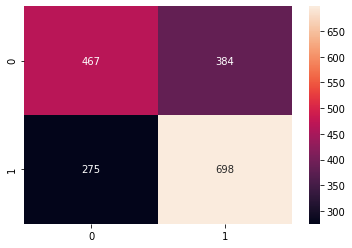

In [ ]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

Y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

In [ ]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           H       0.63      0.55      0.59       851
          NH       0.65      0.72      0.68       973

    accuracy                           0.64      1824
   macro avg       0.64      0.63      0.63      1824
weighted avg       0.64      0.64      0.64      1824



# Applying the SVM

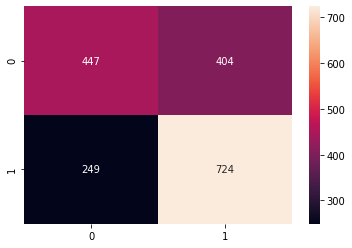

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',random_state = 0)
classifier.fit(X_train, y_train)

#predicting result
Y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           H       0.64      0.53      0.58       851
          NH       0.64      0.74      0.69       973

    accuracy                           0.64      1824
   macro avg       0.64      0.63      0.63      1824
weighted avg       0.64      0.64      0.64      1824



# Applying the RandomForest

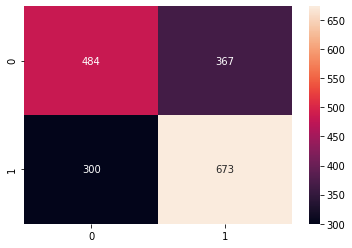

In [ ]:
#fitting the RANDOM FOREST to the training se
from sklearn.ensemble import RandomForestClassifier
#classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
classifier.fit(X_train, y_train)

#predicting result
Y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)

sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           H       0.62      0.57      0.59       851
          NH       0.65      0.69      0.67       973

    accuracy                           0.63      1824
   macro avg       0.63      0.63      0.63      1824
weighted avg       0.63      0.63      0.63      1824

